Multiple maps using subplots
=============================

In [1]:
import ee
import cartoee as cee
import cartopy.crs as ccrs

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ee.Initialize()

### Seasonal NDVI example

In this example we will compute the seasonal average NDVI values for the globe and plot the four seasons on the same figure.

In [3]:
# function to add NDVI band to imagery
def calc_ndvi(img):
    ndvi = img.normalizedDifference(['Nadir_Reflectance_Band2','Nadir_Reflectance_Band1'])
    return img.addBands(ndvi.rename('ndvi'))

In [4]:
# MODIS Nadir BRDF-Adjusted Reflectance with NDVI band
modis = ee.ImageCollection('MODIS/006/MCD43A4')\
        .filterDate('2010-01-01','2016-01-01')\
        .map(calc_ndvi)

In [5]:
# set parameters for plotting
ndviVis = {'min':0,'max':1,'bands':'ndvi'}
bbox = [-180,-60,180,90]

In [6]:
# get land mass feature collection
land = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# calculate seasonal averages and clip to land features
djf = modis.filter(ee.Filter.calendarRange(12,3,'month')).mean().clip(land)
mam = modis.filter(ee.Filter.calendarRange(3,6,'month')).mean().clip(land)
jja = modis.filter(ee.Filter.calendarRange(6,9,'month')).mean().clip(land)
son = modis.filter(ee.Filter.calendarRange(9,12,'month')).mean().clip(land)

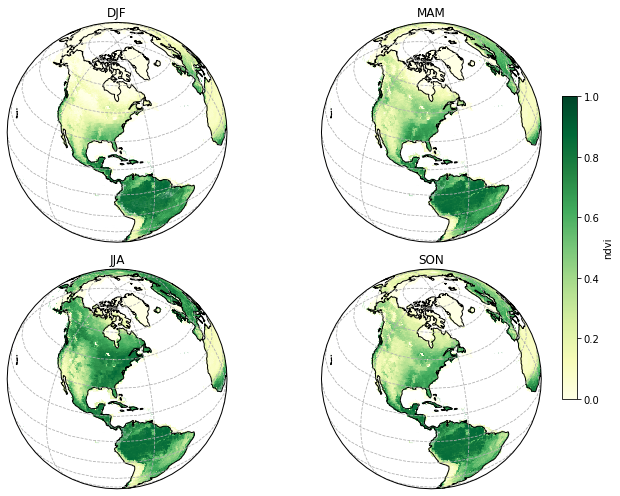

In [7]:
# set up a blank map with multiple subplots
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,7),
                      subplot_kw={'projection': ccrs.Orthographic(-80,35)})

# format images and subplot titles with same dimensions as subplots
imgs = np.array([[djf,mam],[jja,son]])
titles = np.array([['DJF','MAM'],['JJA','SON']])

for i in range(len(imgs)):
    for j in range(len(imgs[i])):
        ax[i,j] = cee.addLayer(imgs[i,j],ax=ax[i,j],
                               region=bbox,dims=500,
                               visParams=ndviVis,cmap='YlGn'
                              )
        ax[i,j].coastlines()
        ax[i,j].gridlines(linestyle='--')
        ax[i,j].set_title(titles[i,j])
        
plt.tight_layout()
        
cax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cb = cee.addColorbar(ax[i,j],cax=cax,cmap='YlGn',visParams=ndviVis)

plt.show()

### Map inset example

In this example we are going to take a regional image from EE, plot the entire region, and plot a smaller country within the region as a subset. This specific example will create a map for West Africa showing a Landsat mosaic and create an inset map of Senegal using the same Landsat mosaic.

In [8]:
# get a country FeatureCollection
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
# filter the countries for a specific county
country = 'Senegal'
senegal = ee.Feature(countries.filter(ee.Filter.eq('country_na',country)).first())
# create an ee.Image from a FeatureCollection
adminImg = ee.Image().paint(countries,color='#000000',width=4)

# get a Landsat mosaic for West Africa
waLandsat = ee.Image('projects/servir-wa/regional_west_africa/Landsat_SR/Landsat_SR_prewet_2012_2014')
# specify the visualization parameters
lsVis = {'min':50,'max':5500,'gamma':1.5,'bands':'swir2,nir,green'}

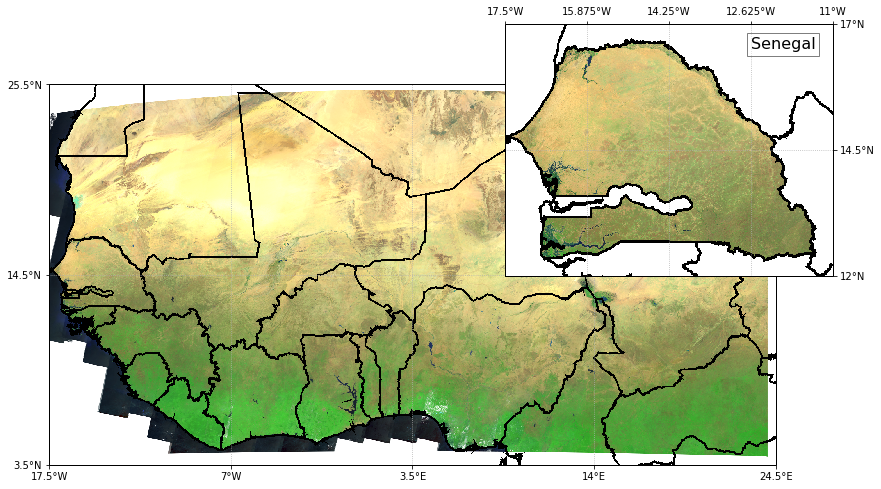

In [9]:
# import some styling functions
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

# setup blank figure
fig = plt.figure(figsize=(15,7))

# region for the main map
mainBox = [-17.5,3.5,24.5,25.5]

# set blank map for the main plot and add layers
ax_main = fig.add_subplot(1, 1, 1,projection=ccrs.PlateCarree())
ax_main = cee.addLayer(waLandsat,visParams=lsVis,region=mainBox,dims=2500,ax=ax_main)
ax_main = cee.addLayer(adminImg,region=mainBox,dims=1500,ax=ax_main)

# main map styling
xmain = np.linspace(-17.5,24.5,5)
ymain = np.linspace(3.5,25.5,3)
ax_main.gridlines(xlocs=xmain, ylocs=ymain,linestyle=':')
# set custom formatting for the tick labels
ax_main.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax_main.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# set tick labels
ax_main.set_xticks(xmain, crs=ccrs.PlateCarree())
ax_main.set_yticks(ymain, crs=ccrs.PlateCarree())


# region for the map inset
insetBox = [-17.5,12,-11,17]

# setup inset map and add layers
ax_inset = fig.add_axes([0.45, 0.5, 0.6, 0.5],projection=ccrs.PlateCarree())
ax_inset = cee.addLayer(waLandsat.clip(senegal),visParams=lsVis,region=insetBox,dims=2500,ax=ax_inset)
ax_inset = cee.addLayer(adminImg,region=insetBox,ax=ax_inset)

# inset map styling
xinset = np.linspace(-17.5,-11,5)
yinset = np.linspace(12,17,3)
ax_inset.gridlines(xlocs=xinset, ylocs=yinset,linestyle=':')
# set custom formatting for the tick labels
ax_inset.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax_inset.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax_inset.xaxis.tick_top()
ax_inset.yaxis.tick_right()
# set inset tick labels
ax_inset.set_xticks(xinset, crs=ccrs.PlateCarree())
ax_inset.set_yticks(yinset, crs=ccrs.PlateCarree())

# add some text to the inset as a pseudo-title
ax_inset.text(-12.63,16.5,country,fontsize=16,bbox=dict(facecolor='white', alpha=0.5,edgecolor='k'))

plt.show()